usando uma imagem de tamanho menor:
 407 x 540

Dataset maior 30k 

In [ ]:
#
#  ambiente..
#
# ref https://colab.research.google.com/drive/151805XTDg--dgHb3-AXJCpnWaqRhop_2#scrollTo=qvyB0VG4j4zx

#GPU count and name
!nvidia-smi -L

#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'

#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

!lscpu | grep "L3 cache" 

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"

#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

#hard disk space that we can use
!df -h / | awk '{print $4}'


GPU 0: Tesla T4 (UUID: GPU-0dc96bde-dbf9-f23e-d84f-362c76346aa6)
Thu Jan 21 14:33:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                       

In [ ]:
#
# mount and unzip
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#
# initialize...
#
checkdir_pre= "v141/try13-ds034-v4/1002"
checkdir    = "v141/try13-ds034-v4/1003"

NO_TEACH= True
FREEZE_ENCODER= False
TRAIN_LENGTH= 16
BATCH_SIZE = 32
EMBEDDING_DIM = 256
UNITS = 512
LEARNING_RATE=0.0005
# NUM_OF_WORDS= 220
SAMPLED= True
# VOCAB_SIZE= NUM_OF_WORDS+1 
SAVE_IF_BETTER_THAN_LOSS= 0.0   #dont save
_best_loss= 10  # best loss until now


In [ ]:
#
# Ref=> https://www.tensorflow.org/tutorials/text/image_captioning
# https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2
#
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np  
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import cv2
from sklearn.utils import shuffle
from google.colab import drive
from pathlib import Path
import random
print(tf.__version__) 

Found GPU at: /device:GPU:0
2.4.0


In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/v6-labels-only.zip'

In [ ]:
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/dataset-v034--2lines-parts--40k-v4.zip'

In [ ]:
# 
# unzipN

#
!unzip -q '/content/drive/My Drive/mestrado/public/datasets/new-random-8lines--v1--test-only-2lines.zip'

In [ ]:
# !unzip -q '/content/drive/My Drive/mestrado/public/datasets/unified/unified-all-labels-noponct.zip'

In [ ]:
#
# basics
#
tstart= time.time()
def print_time():
  end = time.time()
  hours, rem = divmod(end-tstart, 3600)
  minutes, seconds = divmod(rem, 60)
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print_time()

def read_label( path):
  f= open( path)
  d= f.read()
  f.close()
  return d 

def show_image( img, name= 'noname'):
  plt.imshow( img)
  plt.title( name)
  plt.show()

00:00:00.00


In [ ]:
#
# tokenizer
#
def build_tokenizer():
  with open('/content/new-random-8lines--v1--test-only-2lines/all-labels-shuffle.pgn') as file:
    labels = [line.strip() for line in file]
  labels= ['<start> ' + label + ' <end>' for label in labels]

  # Choose the top 5000 words from the vocabulary
  print( 'building...')
  top_k = 5000   # para ajustar ao modelo antigo...
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                    lower=False,
                                                    oov_token="<unk>",
                                                    filters= ' ')
                                                    # filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

  #forca a usar sempre uma lista com todas as words com 1 ocorrecia de cada word
  tokenizer.fit_on_texts(labels)
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'
  return tokenizer

# NEW tokenizer
tokenizer= build_tokenizer()
print( 'total do vocabularario= ', len(tokenizer.word_index))    # expected 1578
# print( 'considerados no encoding= ', NUM_OF_WORDS)

VOCAB_SIZE= len(tokenizer.word_index)+1 
print( 'VOCAB_SIZE', VOCAB_SIZE)

building...
total do vocabularario=  179
VOCAB_SIZE 180


In [ ]:
#
# load images and labels
#
# def cleanup(line):
#     return re.sub('[^0-9a-zA-Z -]+', '', line).replace( 'x', '')

def load_data_from( path):
	image_files= glob( os.path.join( path, 'images/*.jpg'))
	image_files.sort()

	label_files= glob( os.path.join( path, 'labels/*.pgn'))
	label_files.sort()
	labels= [read_label( f) for f in label_files]
	# labels= [cleanup( x).lower() for x in labels]
	labels= ['<start> ' + label + ' <end>' for label in labels]

	# poderia ser menor... mas pega os primeiros 10. Nem precisava restringir...
	labels= [label.split()[0:16+1] for label in labels]

	# somente uma parte por enquanto
	if SAMPLED:
		n= int( len( image_files)*0.50)
		combined= list( zip( image_files, labels))
		random.Random(0).shuffle(combined)
		image_files[:], labels[:]= zip( *combined[:n])
		print( "SAMPLED!!  size= ", len( image_files), len( labels))

	label_indexes = tokenizer.texts_to_sequences(labels)
	for i in range( 0, 3):
		print( labels[i], '=>', label_indexes[i])
 
	return image_files, label_indexes, labels

#shuffle
# train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/shuffle_8lines_32K/train')
# valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/shuffle_8lines_32K/valid')

#final
train_img_names, train_label_indexes, train_label_words= load_data_from( '/content/dataset-v034--2lines-parts--40k-v4/train')
valid_img_names, valid_label_indexes, valid_label_words= load_data_from( '/content/dataset-v034--2lines-parts--40k-v4/valid')

SAMPLED!!  size=  17793 17793
['<start>', 'Nc6', 'e6', 'Ne1', 'Nc6', '<end>'] => [2, 57, 96, 4, 57, 178]
['<start>', 'Ba5', 'g3', 'Bb4+', 'Bxc3+', '<end>'] => [2, 89, 108, 103, 41, 178]
['<start>', 'e4', 'g6', 'd4', 'Bg7', '<end>'] => [2, 3, 86, 47, 171, 178]
SAMPLED!!  size=  4401 4401
['<start>', 'e4', 'Bd7', 'a4', 'Nb6', '<end>'] => [2, 3, 168, 107, 77, 178]
['<start>', 'Nce7', 'e5', 'e5', 'Nc6', '<end>'] => [2, 43, 109, 109, 57, 178]
['<start>', 'Nf3', 'Nf6', 'g3', 'g6', '<end>'] => [2, 71, 169, 108, 86, 178]


In [ ]:
#
# PREPROCESSAMENTO...
#

In [ ]:
#
# carrega VGG19
#
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape= (200, 862, 3))  # => gera (16, 19, 2048)
                                                # input_shape= (900, 678, 3))  # => gera (16, 19, 2048)
                                                # O input shape nao é obrigatorio, mas setando dá para
                                                # ver o tamanho do output
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
print( image_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 862, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 862, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 862, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 431, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 431, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 431, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 215, 128)      0     

In [ ]:
# -1 gera (None, 18, 21, 512)
ATTENTION_SHAPE= (12,53) #(28,21)
FEATURES_SHAPE = 512
ATTENTION_FEATURES_SHAPE = ATTENTION_SHAPE[0]*ATTENTION_SHAPE[1]  #16*19   # 308

In [ ]:
#
# build cache por preprocessed images
#
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (200, 862)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.image.resize(img, (540, 407)) #(450, 339))  #original=(576, 678, 3)
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, image_path
	
def build_cache_for( img_name_vector):
  encode_train = sorted(set(img_name_vector))

  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8) #(16)

  for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
	  
	  
build_cache_for( train_img_names)
build_cache_for( valid_img_names)

In [ ]:
#
# build dataset
#

In [ ]:
# Load the numpy files
BUFFER_SIZE = 1000
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
  

def build_dataset( img_names, label_indexes):
  # deixa no mesmo tamanho, maximo 32
  label_indexes= [label[:32] for label in label_indexes]
  label_indexes= tf.keras.preprocessing.sequence.pad_sequences(label_indexes, padding='post')

  dataset = tf.data.Dataset.from_tensor_slices((img_names, label_indexes))

  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE, seed= 0).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

  
train_dataset= build_dataset( train_img_names, train_label_indexes)
valid_dataset= build_dataset( valid_img_names, valid_label_indexes)

train_num_steps= len( train_img_names)//BATCH_SIZE
valid_num_steps= len( valid_img_names)//BATCH_SIZE

In [ ]:
#
# Model
#

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # print( 'BahdanauAttention.features =>', features.shape) #(64, 64, 256), segundo 64=length(encoder_output)
    # print( 'BahdanauAttention.hidden =>', hidden.shape) #(64, 512)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # print( 'BahdanauAttention.hidden_with_time_axis =>', hidden_with_time_axis.shape) #(64, 1, 512)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
    # print( 'BahdanauAttention.score =>', score.shape)   #(64, 64, 512)

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # print( 'BahdanauAttention.attention_weights =>', attention_weights.shape)  #(64, 64, 1) segundo 64 vem do tamanho da sequencia apos cnn

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape)  #(64, 64, 256) segundo 64= length(encoder_output)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # print( 'BahdanauAttention.context_vector =>', context_vector.shape) #(64, 256)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):

    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim, units):
        super(CNN_Encoder, self).__init__()
        self.units = units
        # shape after fc == (batch_size, 64, embedding_dim)
        # self.gru1= tf.keras.layers.GRU(self.units,
                                  #      dropout= ENCODER_DROPOUT,
                                  #  return_sequences=True) 
        self.bgru= tf.keras.layers.Bidirectional( tf.keras.layers.GRU(self.units,
                                       dropout= 0.2,
                                   return_sequences=True)) 
        self.drop= tf.keras.layers.Dropout( 0.2)
        # self.gru= tf.keras.layers.GRU(self.units,
        #                            return_sequences=True)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.bgru( x)
        # x = self.bgru2( x)
        x = self.drop(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU( self.units,
                                   dropout= 0.2,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # self.gru.trainable= False
    self.fc1 = tf.keras.layers.Dense(self.units)    #512
    # self.fc2 = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0001))    #256
    self.fcF = tf.keras.layers.Dense(vocab_size)    # 120

    # self.bn0 = tf.keras.layers.BatchNormalization()
    # self.bn1 = tf.keras.layers.BatchNormalization()
    # self.bn2 = tf.keras.layers.BatchNormalization()

    # self.drop0= tf.keras.layers.Dropout( 0.7)
    self.drop= tf.keras.layers.Dropout( 0.2)
    # self.drop2= tf.keras.layers.Dropout( 0.7)

    # self.dropout = tf.keras.layers.Dropout(0.5)
    # self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, 
    #                     center=True, scale=True, beta_initializer='zeros', 
    #                     gamma_initializer='ones', moving_mean_initializer='zeros', 
    #                     moving_variance_initializer='ones', beta_regularizer=None, 
    #                     gamma_regularizer=None, beta_constraint=None, 
    #                     gamma_constraint=None)

    self.attention = BahdanauAttention(self.units)
    if FREEZE_ENCODER:
      self.attention.trainable = False

  def freeze_attention(self):
      self.attention.trainable = False

  def call(self, x, features, hidden):
    # print( 'decoder.call=> ', x.shape, features.shape, hidden.shape) #(64, 1) (64, 64, 256) (64, 512)

    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    # print( 'decoder.attention=> ', context_vector.shape, attention_weights.shape) #(64, 256) (64, 64, 1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # print( 'decoder.embedding=> ', x.shape) #(64, 1, 256)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # print( 'decoder.concat=> ', x.shape) #(64, 1, 512)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output = self.bn0(output)
    # output = self.drop0(output)

    x = self.fc1(output)    #fc1= Dense( 512)
    # x= output
    # x = self.bn1(x)
    x = self.drop(x)

    x = tf.reshape(x, (-1, x.shape[2])) 
    # x = self.fc2(x) # 256
    # x = self.bn2(x)
    # x = self.drop2(x)

    # x= self.dropout(x)
    # x= self.batchnormalization(x)
    x = self.fcF(x) #fc2= Dense(5000)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
# 
# build the model
#

In [ ]:
encoder = CNN_Encoder(EMBEDDING_DIM, UNITS)
if FREEZE_ENCODER:
  encoder.trainable = False

decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # print( 'loss_function.real, pred', real.shape, pred.shape)  #(64,) (64, 5001)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
#
# checkpoint manager
#

In [ ]:
def build_and_recover_checkpoint( checkdir_pre, checkdir):
  ckpt = tf.train.Checkpoint(encoder=encoder,
                              decoder=decoder,
                              optimizer = optimizer)
                              
  checkpoint_path = "/content/drive/My Drive/mestrado/"+checkdir+"/checkpoints/train"
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

  epoch = 0
  if ckpt_manager.latest_checkpoint:
    print( "restoring from current "+ ckpt_manager.latest_checkpoint)
    epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    print( '_epoch= ', epoch)
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)
  elif not checkdir_pre is None:
    checkpoint_pre_path = "/content/drive/My Drive/mestrado/"+checkdir_pre+"/checkpoints/train"
    lastest_pre= tf.train.latest_checkpoint(checkpoint_pre_path)
    if lastest_pre:
      print( "restore from pretraining  "+ lastest_pre, '...')
      ckpt.restore( tf.train.latest_checkpoint(checkpoint_pre_path))
  else:
      pass
  return ckpt_manager, ckpt, epoch

def restore_checkpoint_to_last():
  if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print( 'restored!', ckpt_manager.latest_checkpoint)
  else:
    print( 'no checkpoint found!!')

ckpt_manager, ckpt, _epoch= build_and_recover_checkpoint( checkdir_pre, checkdir)

restore from pretraining  /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1002/checkpoints/train/ckpt-24 ...


In [ ]:
#
# training
#

In [ ]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
valid_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

def reset_metric_plot():
  global loss_plot_train, loss_plot_valid, acc_plot_train, acc_plot_valid
  loss_plot_train = []
  loss_plot_valid = []
  acc_plot_train = []
  acc_plot_valid = []
reset_metric_plot()

def plot_metrics():
  plt.plot(loss_plot_train)
  plt.plot(loss_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Plot')
  plt.gca().legend(('train loss','validation loss'))
  plt.show()

  plt.plot(acc_plot_train)
  plt.plot(acc_plot_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.title('Acc Plot')
  plt.gca().legend(('train acc','validation acc'))
  plt.show()  

In [ ]:
@tf.function
def train_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)

    for i in range(1, train_length+1): 
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      # tf.keras.backend.print_tensor( predictions)
      # tf.keras.backend.print_tensor( tf.reduce_max( predictions))
      # tf.keras.backend.print_tensor( tf.reduce_min( predictions))

      loss += loss_function(target[:, i], predictions)
      train_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))

  # update model
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
def call_train_step_for_debug():
  batch, (img_tensor, target)= next( enumerate(train_dataset))
  batch_loss, t_loss = train_step(img_tensor[0:1], target[0:1], 4)
  print( 'loss= ', batch_loss.numpy())

# call_train_step_for_debug()

In [ ]:
#
# call train without update the gradient
#
@tf.function
def test_step(img_tensor, target, train_length):
  loss = 0
  zeros= np.zeros(target.shape[0]).astype(int)

  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims(
      zeros if NO_TEACH else [tokenizer.word_index['<start>']] * target.shape[0], 1)
  features = encoder(img_tensor)

  for i in range(1, train_length+1):
      predictions, hidden, _ = decoder(dec_input, features, hidden)

      loss += loss_function(target[:, i], predictions)
      valid_acc_metric.update_state(target[:, i], predictions)

      dec_input = tf.expand_dims(zeros if NO_TEACH else target[:, i], 1)

  total_loss = (loss / int(train_length))
  return loss, total_loss


In [ ]:
def train_more( loss_target, train_length, val_loss_limit): #, n_epoch):
  global _epoch
  global _best_loss

  MAX_EPOCH=200 

  print( "-- loss_target=>", loss_target, " train_length=", train_length)
  for _ in range(0,MAX_EPOCH):
      _epoch+= 1
      start = time.time()
      total_loss = 0
      
      train_acc_metric.reset_states()
      valid_acc_metric.reset_states()

      #
      # training loop
      #
      for (batch, (img_tensor, target)) in enumerate(train_dataset):
          batch_loss, t_loss = train_step(img_tensor, target, train_length)
          total_loss += t_loss

          if batch % 50 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(
                _epoch, batch, batch_loss.numpy() / train_length))

      train_loss= total_loss/train_num_steps
      loss_plot_train.append(train_loss)
      train_acc = float(train_acc_metric.result())
      acc_plot_train.append(train_acc)

      #
      # validation loop
      #
      valid_total_loss = 0
      for (batch, (img_tensor, target)) in enumerate(valid_dataset):
          batch_loss, t_loss = test_step(img_tensor, target, train_length)
          valid_total_loss += t_loss
      valid_loss= valid_total_loss / valid_num_steps
      loss_plot_valid.append(valid_loss)
      valid_acc = float(valid_acc_metric.result())
      acc_plot_valid.append(valid_acc)

      #
      # print..
      #

      print ('Epoch {} Loss {:.6f}  acc: {:.4f} [ Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                                  _epoch,
                                  train_loss, 
                                  train_acc,
                                  valid_loss, 
                                  valid_acc))
      print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
      print_time()    


      # 
      # target reached?
      #
      if loss_target> 0 and (train_loss)<= loss_target:
        print( "Target reached! stop!", ' len= ', train_length)

        ckpt_manager.save()  
        print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)
        plot_metrics()
        return True

      if train_loss< _best_loss:
        _best_loss= train_loss
        print( 'New record! _best_loss= ', _best_loss)
        if train_loss< SAVE_IF_BETTER_THAN_LOSS :
            ckpt_manager.save()  
            print( 'saved checkpoint!', ckpt_manager.latest_checkpoint)

      # se validacao estoura significa que esta desaprendendo attention, portanto faz abort
      # TODO: Como implementar early stop?
      if valid_loss>= val_loss_limit:   
        print( "Oops, desaprendendo. Aborta sem salvar!")
        return False

  print( 'epoch exceeded')
  return False
    

In [ ]:
MAX_RETRY= 0
def train_more_with_retry( loss_target, _length, valid_loss_limit):
  retry_count= 0
  while True:
    print( 'len=', _length, ' try_count=', retry_count)
    ok= train_more( loss_target, _length, valid_loss_limit)
    if ok: 
      return True

    if retry_count>= MAX_RETRY:
      print( 'givup!')
      return False
    retry_count+= 1

    #volta para inicio da iteracao anterior
    restore_checkpoint_to_last()
  return False


In [ ]:
def evaluate(image, _length, no_teach= True):
    # print( 'evaluate>>')
    # print( "_length", _length)

    attention_plot = np.zeros((32, ATTENTION_FEATURES_SHAPE))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([0 if no_teach else tokenizer.word_index['<start>']], 0)
    result = []
    # result_top5 = []

    for i in range(_length): 
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id] if predicted_id< len( tokenizer.index_word) else "OUT")

        # predicted_id_top5= tf.math.top_k( predictions, 10)[1][0].numpy()
        # result_top5.append( [tokenizer.index_word[id] for id in predicted_id_top5])
        dec_input = tf.expand_dims([0 if no_teach else predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, None

In [ ]:
def plot_attention(image, result, attention_plot, expected= None):
  print( image)
  temp_image = np.array(Image.open(image))

  fig = plt.figure(figsize=(50, 50))

  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], ATTENTION_SHAPE) 
    ax = fig.add_subplot(8, 9, l+1)
    if expected is None or l>= len( expected):
      ax.set_title(result[l], fontsize= 40)
    else:
      ax.set_title(result[l]+" ("+expected[l]+")", fontsize= 40)
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()


In [ ]:
def evaluate_random_from_dataset( image_path, label_words, train_length):
  result, attention_plot, _ = evaluate(image_path, train_length)

  # TODO: Pode estar errado...
  m = tf.keras.metrics.Accuracy()
  m.update_state( 
          tokenizer.texts_to_sequences(label_words)[1:train_length+1],
          tokenizer.texts_to_sequences(result)[0:train_length])
          # [tokenizer.word_index[w] for w in label_words][1:train_length+1], 
          # [tokenizer.word_index[w] for w in result][0:train_length])

  # print( 'accurary', float( m.result()))
  print ('expected=', label_words[1:])
  print ('predicted=', result)
  plot_attention(image_path, result, attention_plot, label_words[1:])

def evaluate_train( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( train_img_names[i], train_label_words[i], train_length) 

def evaluate_valid( n, train_length):
  for i in range(0, n):
    evaluate_random_from_dataset( valid_img_names[i], valid_label_words[i], train_length) 

#evaluate_train(1, 32)

In [ ]:
def evaluate_full_valid_dataset(_length):
    total_loss = 0
    valid_acc_metric.reset_states()
    for (batch, (img_tensor, target)) in enumerate(valid_dataset):
        batch_loss, t_loss = test_step(img_tensor, target, _length)
        total_loss += t_loss

    valid_loss= total_loss / valid_num_steps
    valid_acc = float(valid_acc_metric.result())
    print ('len {} Validation Loss {:.6f} valid_acc: {:.4f} ]'.format(
                        _length,
                        valid_loss, 
                        valid_acc))


In [ ]:
#
# Adicionais para teste da acuracia do test set
#

In [ ]:
import nltk
from nltk.metrics import distance

def cir_word( hp, gt):
    return distance.edit_distance(hp, gt)/len( gt)
	
def cir_line( expected, predicted):
    return tf.reduce_mean( [cir_word(e, p) for (e, p) in zip( expected, predicted)]).numpy()

def cir_set( labels, result, _len= None):
    if _len is None:
      _len= len( labels)
    return tf.reduce_mean( [cir_line(e[:_len], p[:_len]) for (e, p) in zip( labels, result)]).numpy()


In [ ]:
def load_from_path( path, max= None):
  test_images= glob( os.path.join( path, 'images/*.jpg'))
  test_images.sort()

  test_labels_files= glob( os.path.join( path, 'labels/*.pgn'))
  test_labels_files.sort()
  test_labels= [read_label( f) for f in test_labels_files]
  # test_labels= [cleanup( x).lower() for x in test_labels]
  test_labels= [label.split() for label in test_labels]
  if max is None:
    return test_images, test_labels
  else:
    return test_images[:max], test_labels[:max]

def load_test():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test') 

def load_test_2():
  return load_from_path( '/content/new-random-8lines--v1--test-only-2lines/test--v2') 
  
def evaluate_all_data(images,labels,maxlen,no_teach=True):
  result_ac= []
  print( 'EVALUATING ALL DATA',len( images))
  # treina todos
  result= []
  # best= { "score": None }
  # worst= { "score": None }
  for i in range(0,len( images)):
    if( i%100== 0):
      print( 'evaluating ', i, '...')
    r, attention_plot, _ = evaluate(images[i], maxlen, no_teach)
    result.append( r)

    # habilitar para exibir resultado e esperado
    if i< 5:
      print( '------------------------', i, '------------------------------')
      print( 'predicted', r)
      print( 'expected', labels[i])

      #habilitar para plotar attention
      plot_attention(images[i], r, attention_plot, labels[i])

  # calcula a acuracia para cada tamanho
  for _len in range(1,maxlen+1):
    m = tf.keras.metrics.Accuracy()

    # acuracia para cada teste, até o tamanho atual
    for i in range( 0, len( result)):
      uselen= min( len( labels[i]), len( result[i]), _len)
      m.update_state( 
              tokenizer.texts_to_sequences(labels[i])[:uselen],
              tokenizer.texts_to_sequences(result[i])[:uselen])
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0 for w in labels[i]][:uselen], 
              # [tokenizer.word_index[w] if w in tokenizer.word_index else 0  for w in result[i]][:uselen])
    
    print( 'len', _len, 'accuracy', float( m.result()), 'cir', cir_set( labels, result, _len))
    result_ac.append( float( m.result()))

  return result_ac

def plot_accuracy( checkpoint, result_acc):
  plt.xlabel('sequence length')
  plt.ylabel('accuracy')
  for r, check_name in result_acc:
    plt.plot(r)
  plt.title('checkpoint: '+ checkpoint)
  plt.gca().legend([check_name for _, check_name in result_acc])
  plt.show()
  
def make_evaluations_test_set(_len):
  # for check_dir, no_teach in checkpoints:
    # print( 'checkpoint', check_dir)
    # restore_from( check_dir)
  result_acc= []
  result_acc.append( (evaluate_all_data(*load_test(), _len), 'test'))
  # result_acc.append( (evaluate_all_data(*load_test_2(), _len), 'test--v2'))
  plot_accuracy( checkdir, result_acc)

# make_evaluations_test_set(1)

In [ ]:
#
# training loop, attention
#

iniciando para lengh 1  target 0.25
len= 1  try_count= 0
-- loss_target=> 0.25  train_length= 1
Epoch 1 Batch 0 Loss 0.0002
Epoch 1 Batch 50 Loss 0.1646
Epoch 1 Batch 100 Loss 0.2426
Epoch 1 Batch 150 Loss 0.1033
Epoch 1 Batch 200 Loss 0.1124
Epoch 1 Batch 250 Loss 0.0454
Epoch 1 Batch 300 Loss 0.1275
Epoch 1 Batch 350 Loss 0.1217
Epoch 1 Batch 400 Loss 0.0021
Epoch 1 Batch 450 Loss 0.3010
Epoch 1 Batch 500 Loss 0.2730
Epoch 1 Batch 550 Loss 0.0675
Epoch 1 Loss 0.146644  acc: 0.9625 [ Validation Loss 0.204410 valid_acc: 0.9486 ]
Time taken for 1 epoch 975.3534944057465 sec

00:28:23.29
Target reached! stop!  len=  1
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-25


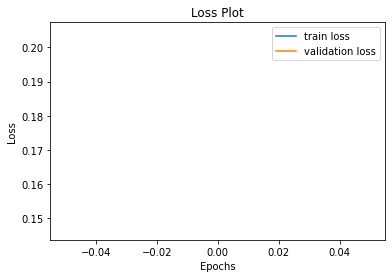

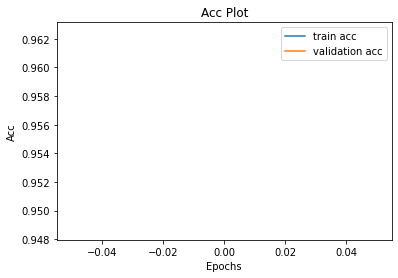

00:28:23.99
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


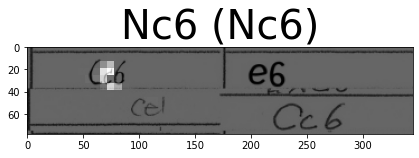

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


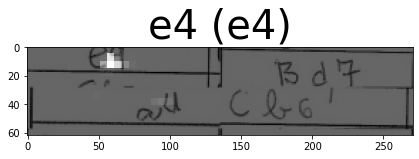

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


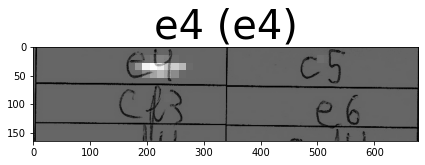

------------------------ 1 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


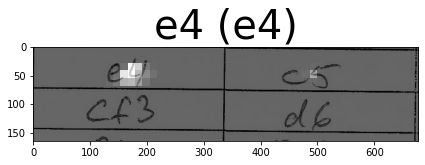

------------------------ 2 ------------------------------
predicted ['Nf3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


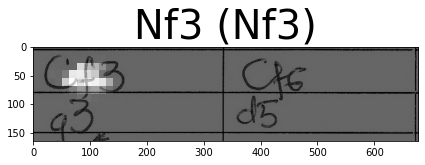

------------------------ 3 ------------------------------
predicted ['c4']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


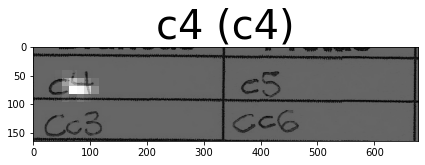

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


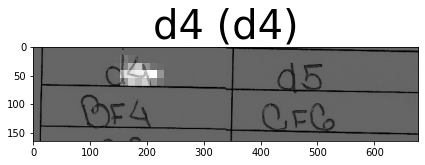

evaluating  100 ...
len 1 accuracy 0.8508771657943726 cir 0.0745614


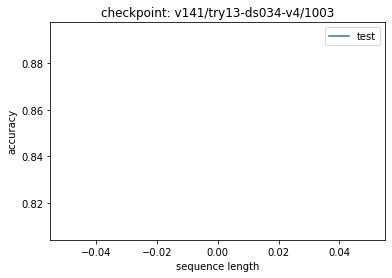

iniciando para lengh 1  target 0.1
len= 1  try_count= 0
-- loss_target=> 0.1  train_length= 1
Epoch 2 Batch 0 Loss 0.0010
Epoch 2 Batch 50 Loss 0.1446
Epoch 2 Batch 100 Loss 0.0256
Epoch 2 Batch 150 Loss 0.0025
Epoch 2 Batch 200 Loss 0.0016
Epoch 2 Batch 250 Loss 0.0085
Epoch 2 Batch 300 Loss 0.0011
Epoch 2 Batch 350 Loss 0.0021
Epoch 2 Batch 400 Loss 0.0144
Epoch 2 Batch 450 Loss 0.0372
Epoch 2 Batch 500 Loss 0.0032
Epoch 2 Batch 550 Loss 0.0041
Epoch 2 Loss 0.034871  acc: 0.9885 [ Validation Loss 0.162261 valid_acc: 0.9584 ]
Time taken for 1 epoch 971.7087249755859 sec

00:47:31.74
Target reached! stop!  len=  1
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-26


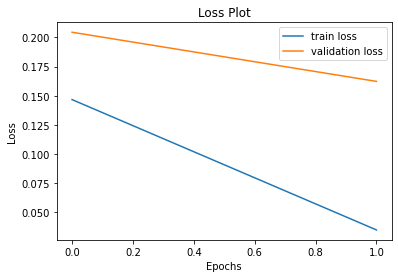

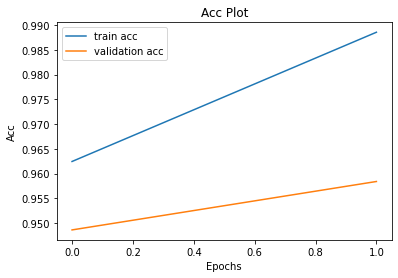

00:47:32.33
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


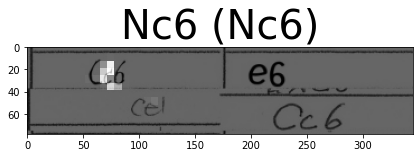

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


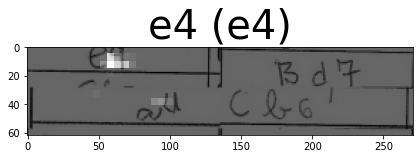

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


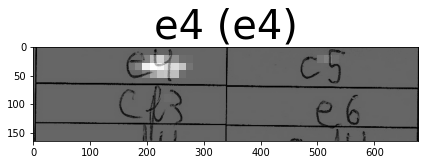

------------------------ 1 ------------------------------
predicted ['e4']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


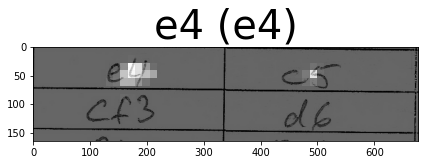

------------------------ 2 ------------------------------
predicted ['Nf3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


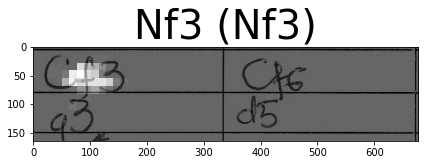

------------------------ 3 ------------------------------
predicted ['c4']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


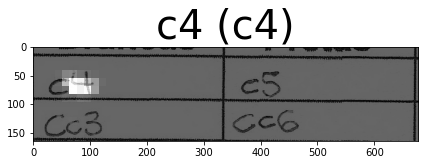

------------------------ 4 ------------------------------
predicted ['d4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


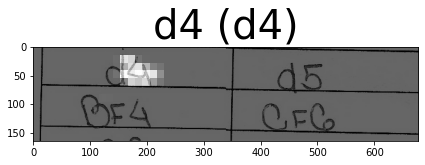

evaluating  100 ...
len 1 accuracy 0.8333333134651184 cir 0.08040936


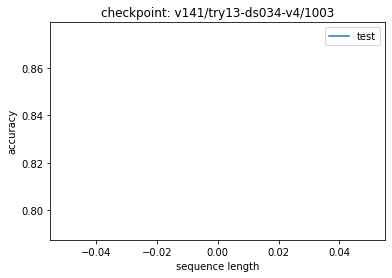

iniciando para lengh 2  target 0.25
len= 2  try_count= 0
-- loss_target=> 0.25  train_length= 2
Epoch 3 Batch 0 Loss 0.0989
Epoch 3 Batch 50 Loss 0.0133
Epoch 3 Batch 100 Loss 0.0637
Epoch 3 Batch 150 Loss 0.0426
Epoch 3 Batch 200 Loss 0.0680
Epoch 3 Batch 250 Loss 0.0757
Epoch 3 Batch 300 Loss 0.0177
Epoch 3 Batch 350 Loss 0.0091
Epoch 3 Batch 400 Loss 0.1630
Epoch 3 Batch 450 Loss 0.0618
Epoch 3 Batch 500 Loss 0.0628
Epoch 3 Batch 550 Loss 0.0190
Epoch 3 Loss 0.081600  acc: 0.9746 [ Validation Loss 0.146646 valid_acc: 0.9609 ]
Time taken for 1 epoch 970.8839874267578 sec

01:06:39.53
Target reached! stop!  len=  2
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-27


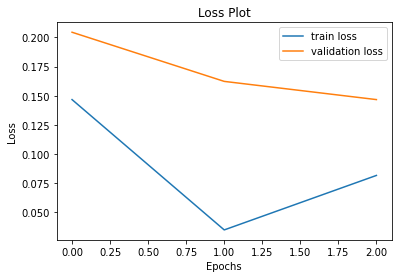

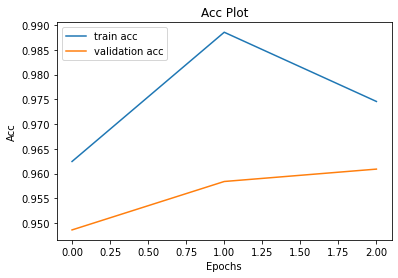

01:06:40.14
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


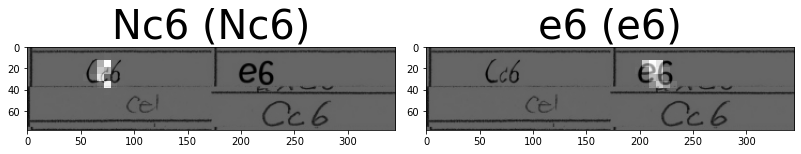

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


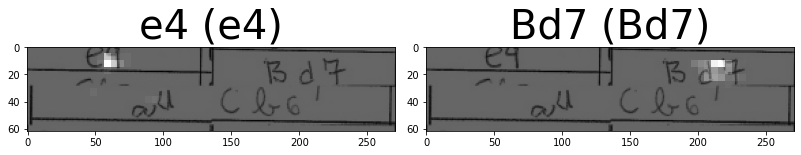

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


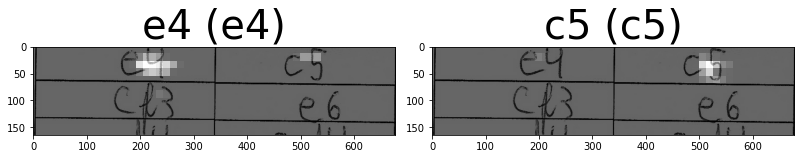

------------------------ 1 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


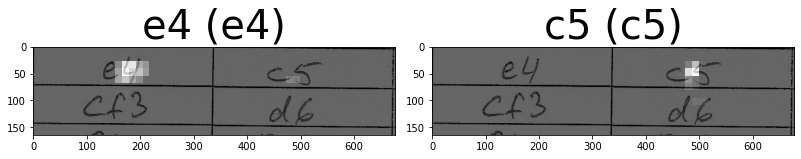

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


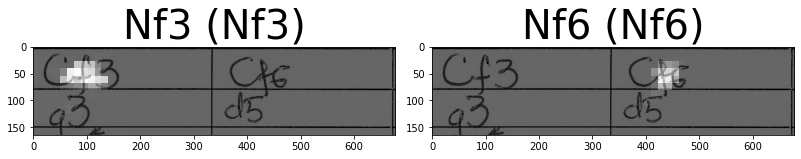

------------------------ 3 ------------------------------
predicted ['c4', 'e5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


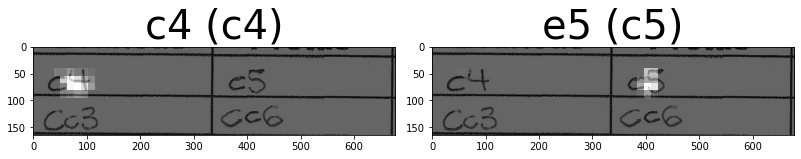

------------------------ 4 ------------------------------
predicted ['d4', 'd5']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


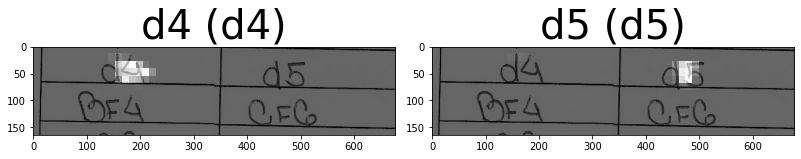

evaluating  100 ...
len 1 accuracy 0.7894737124443054 cir 0.11111111
len 2 accuracy 0.7631579041481018 cir 0.14839181


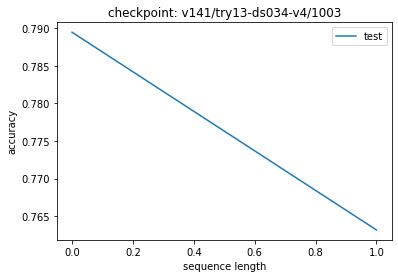

iniciando para lengh 2  target 0.1
len= 2  try_count= 0
-- loss_target=> 0.1  train_length= 2
Epoch 4 Batch 0 Loss 0.0283
Epoch 4 Batch 50 Loss 0.0072
Epoch 4 Batch 100 Loss 0.0108
Epoch 4 Batch 150 Loss 0.0060
Epoch 4 Batch 200 Loss 0.0876
Epoch 4 Batch 250 Loss 0.0015
Epoch 4 Batch 300 Loss 0.1438
Epoch 4 Batch 350 Loss 0.0136
Epoch 4 Batch 400 Loss 0.0681
Epoch 4 Batch 450 Loss 0.0075
Epoch 4 Batch 500 Loss 0.0963
Epoch 4 Batch 550 Loss 0.0488
Epoch 4 Loss 0.036715  acc: 0.9886 [ Validation Loss 0.181022 valid_acc: 0.9548 ]
Time taken for 1 epoch 972.8828556537628 sec

01:25:52.24
Target reached! stop!  len=  2
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-28


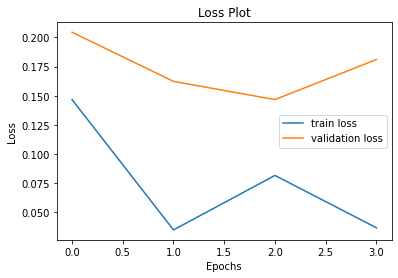

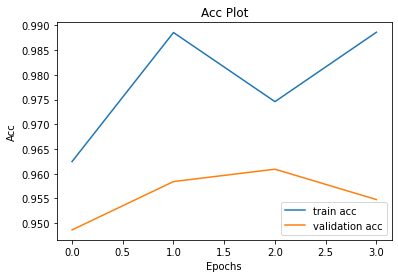

01:25:52.85
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


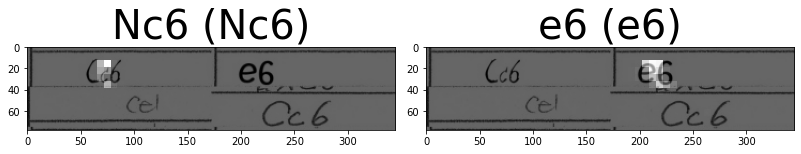

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


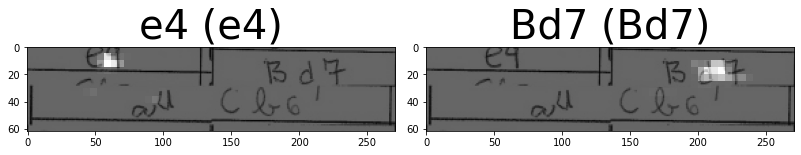

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


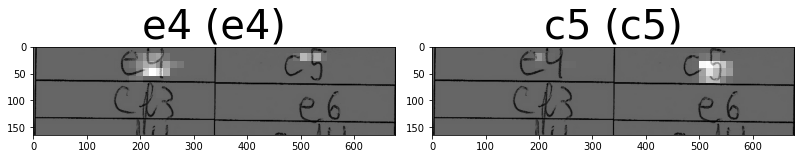

------------------------ 1 ------------------------------
predicted ['e4', 'c5']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


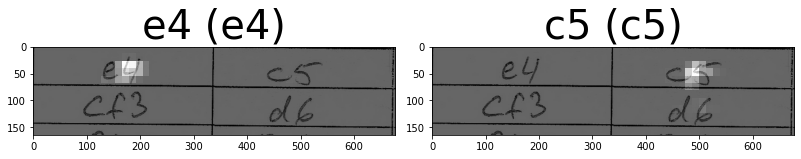

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


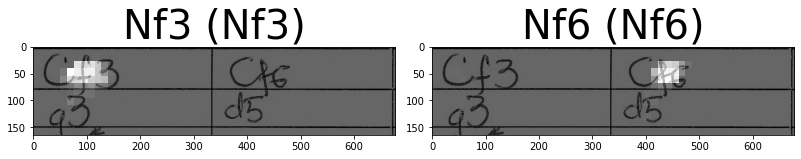

------------------------ 3 ------------------------------
predicted ['c4', 'e5']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


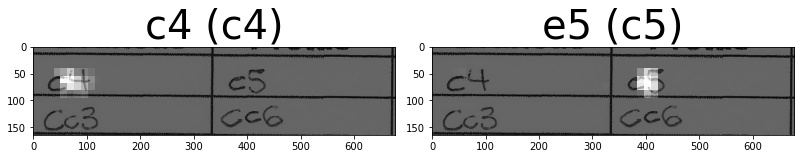

------------------------ 4 ------------------------------
predicted ['d4', 'd6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


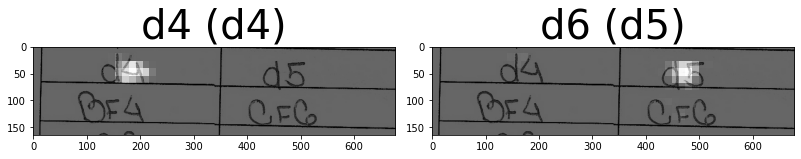

evaluating  100 ...
len 1 accuracy 0.8421052694320679 cir 0.0745614
len 2 accuracy 0.8245614171028137 cir 0.098684214


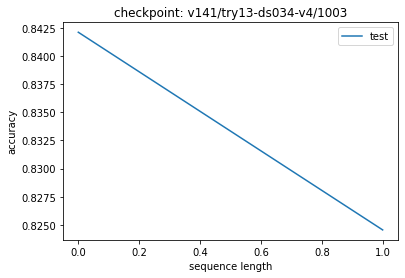

iniciando para lengh 3  target 0.25
len= 3  try_count= 0
-- loss_target=> 0.25  train_length= 3
Epoch 5 Batch 0 Loss 0.1446
Epoch 5 Batch 50 Loss 0.0834
Epoch 5 Batch 100 Loss 0.0739
Epoch 5 Batch 150 Loss 0.0766
Epoch 5 Batch 200 Loss 0.0999
Epoch 5 Batch 250 Loss 0.0221
Epoch 5 Batch 300 Loss 0.0241
Epoch 5 Batch 350 Loss 0.0036
Epoch 5 Batch 400 Loss 0.0133
Epoch 5 Batch 450 Loss 0.0093
Epoch 5 Batch 500 Loss 0.1147
Epoch 5 Batch 550 Loss 0.1581
Epoch 5 Loss 0.071899  acc: 0.9777 [ Validation Loss 0.165236 valid_acc: 0.9539 ]
Time taken for 1 epoch 977.4043705463409 sec

01:45:10.78
Target reached! stop!  len=  3
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-29


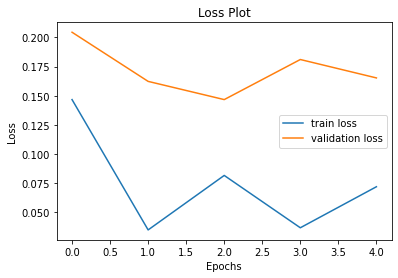

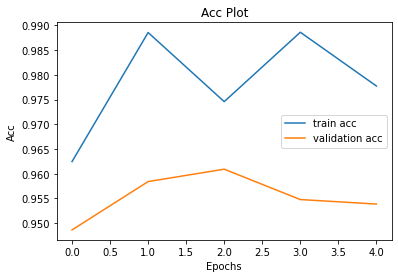

01:45:11.38
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6', 'Ne1']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


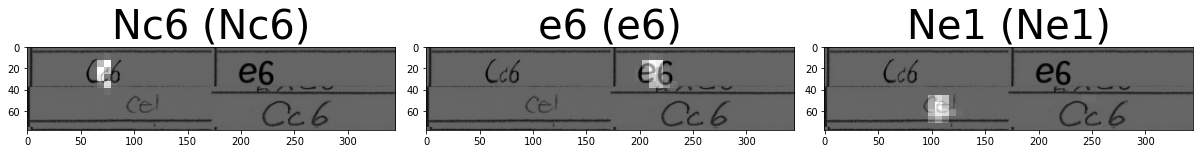

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7', 'a4']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


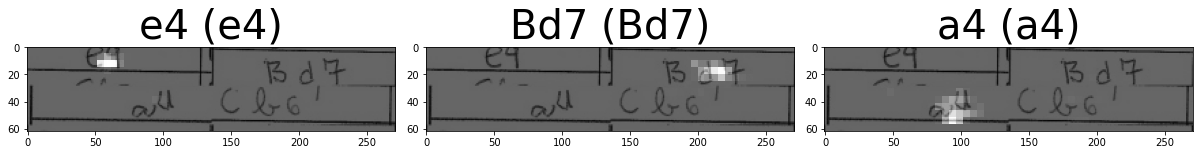

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


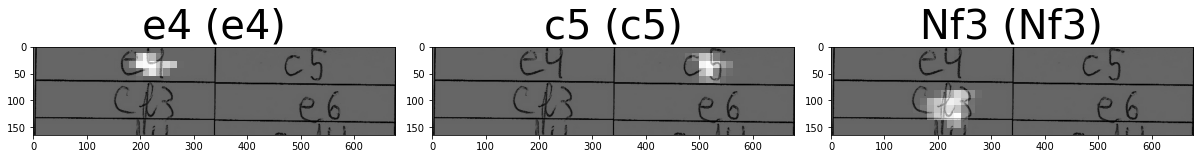

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


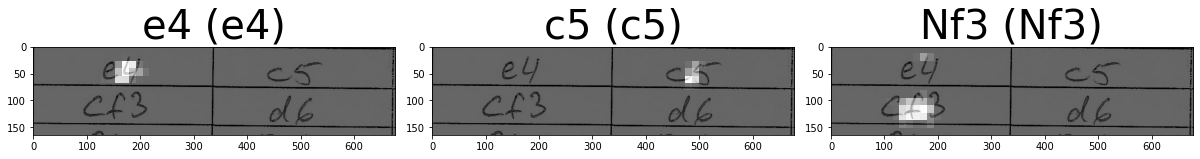

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


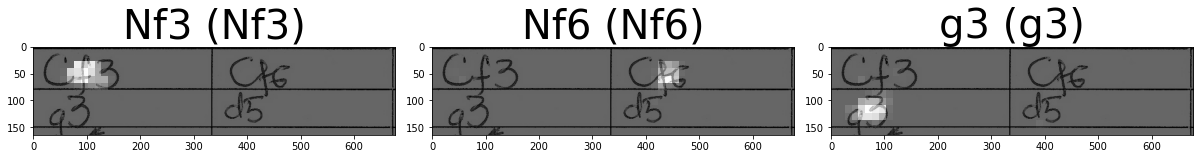

------------------------ 3 ------------------------------
predicted ['c4', 'e3', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


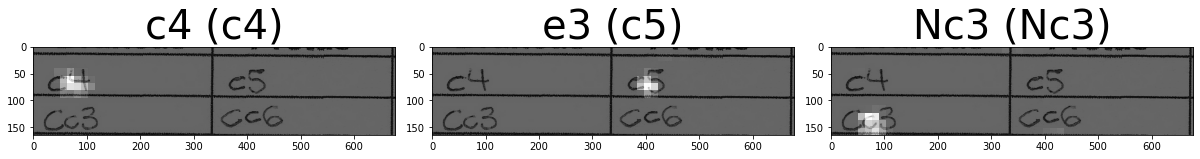

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'c4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


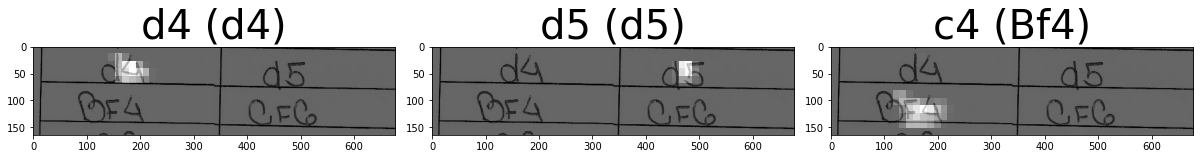

evaluating  100 ...
len 1 accuracy 0.7719298005104065 cir 0.1125731
len 2 accuracy 0.7763158082962036 cir 0.125731
len 3 accuracy 0.7894737124443054 cir 0.1306043


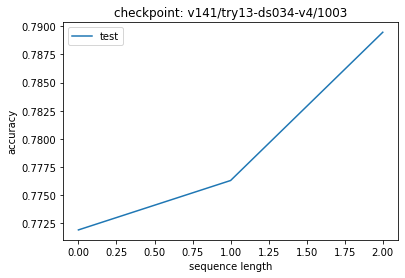

iniciando para lengh 3  target 0.1
len= 3  try_count= 0
-- loss_target=> 0.1  train_length= 3
Epoch 6 Batch 0 Loss 0.0112
Epoch 6 Batch 50 Loss 0.0132
Epoch 6 Batch 100 Loss 0.0308
Epoch 6 Batch 150 Loss 0.0208
Epoch 6 Batch 200 Loss 0.0407
Epoch 6 Batch 250 Loss 0.0351
Epoch 6 Batch 300 Loss 0.0507
Epoch 6 Batch 350 Loss 0.0032
Epoch 6 Batch 400 Loss 0.0165
Epoch 6 Batch 450 Loss 0.0102
Epoch 6 Batch 500 Loss 0.0039
Epoch 6 Batch 550 Loss 0.0176
Epoch 6 Loss 0.029039  acc: 0.9907 [ Validation Loss 0.180019 valid_acc: 0.9581 ]
Time taken for 1 epoch 978.1875352859497 sec

02:04:32.46
Target reached! stop!  len=  3
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-30


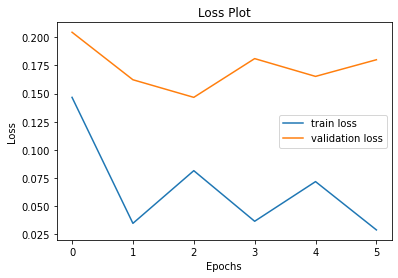

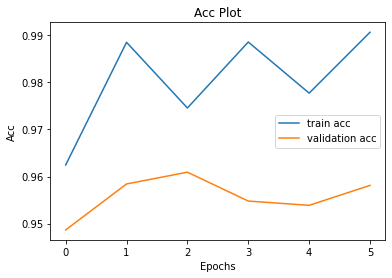

02:04:33.07
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6', 'Ne1']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


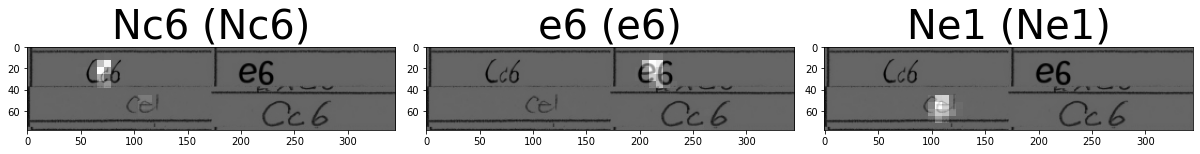

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7', 'a4']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


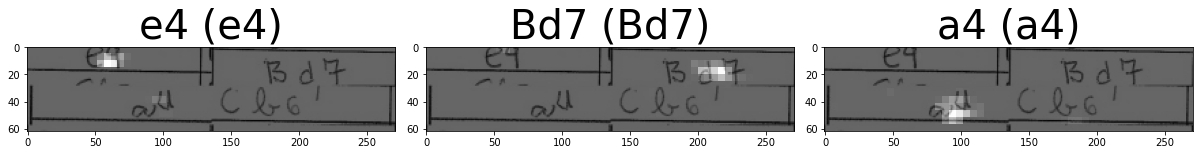

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


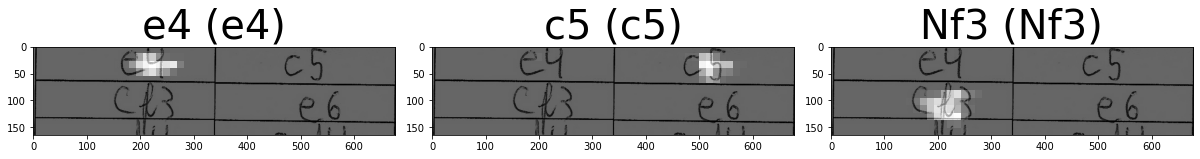

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


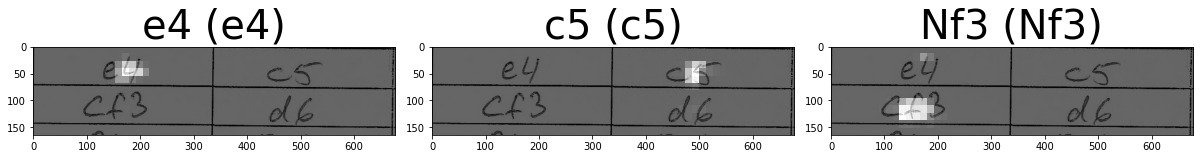

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


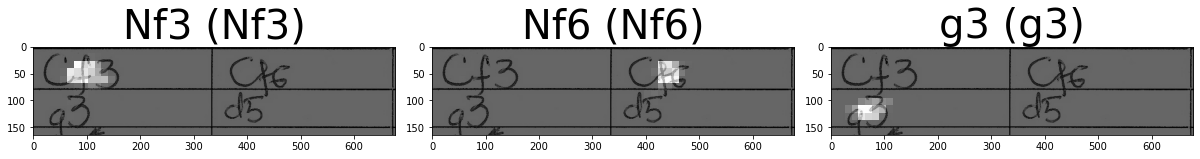

------------------------ 3 ------------------------------
predicted ['c4', 'e6', 'Nc3']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


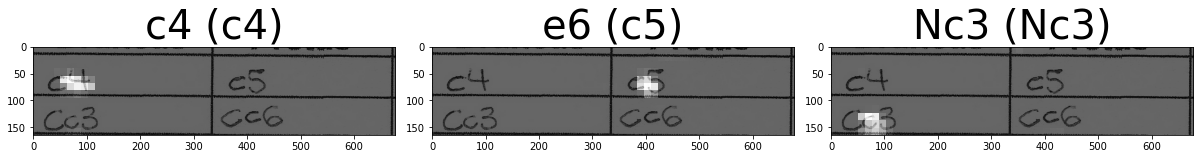

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'Bf4']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


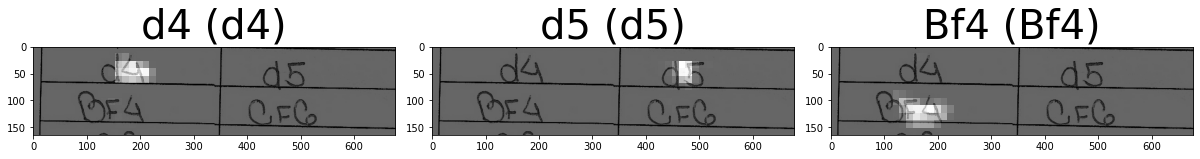

evaluating  100 ...
len 1 accuracy 0.8508771657943726 cir 0.07309942
len 2 accuracy 0.8245614171028137 cir 0.10453217
len 3 accuracy 0.8274853825569153 cir 0.10477583


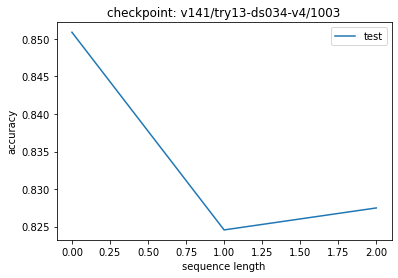

iniciando para lengh 4  target 0.25
len= 4  try_count= 0
-- loss_target=> 0.25  train_length= 4
Epoch 7 Batch 0 Loss 1.4259
Epoch 7 Batch 50 Loss 0.0461
Epoch 7 Batch 100 Loss 0.1195
Epoch 7 Batch 150 Loss 0.0704
Epoch 7 Batch 200 Loss 0.1886
Epoch 7 Batch 250 Loss 0.0117
Epoch 7 Batch 300 Loss 0.0111
Epoch 7 Batch 350 Loss 0.0400
Epoch 7 Batch 400 Loss 0.1204
Epoch 7 Batch 450 Loss 0.0659
Epoch 7 Batch 500 Loss 0.0757
Epoch 7 Batch 550 Loss 0.0438
Epoch 7 Loss 0.069662  acc: 0.9787 [ Validation Loss 0.162066 valid_acc: 0.9590 ]
Time taken for 1 epoch 985.3112845420837 sec

02:24:00.94
Target reached! stop!  len=  4
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-31


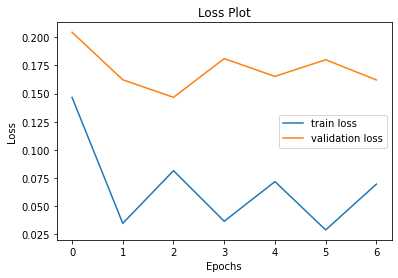

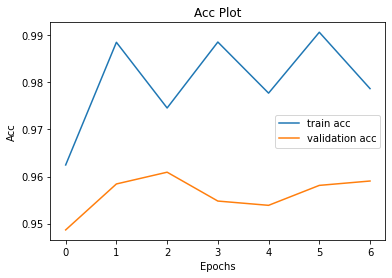

02:24:01.58
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6', 'Ne1', 'Nc6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


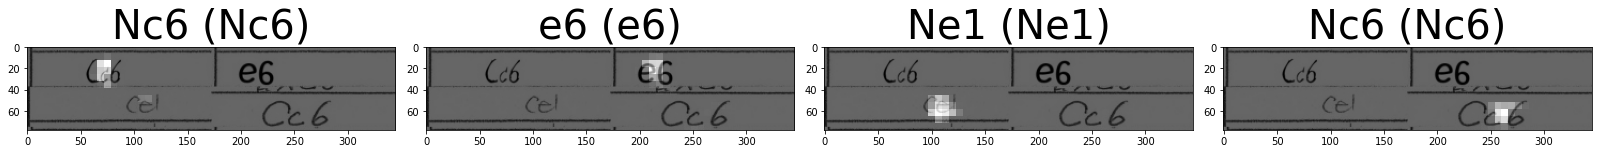

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7', 'a4', 'Nb6']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


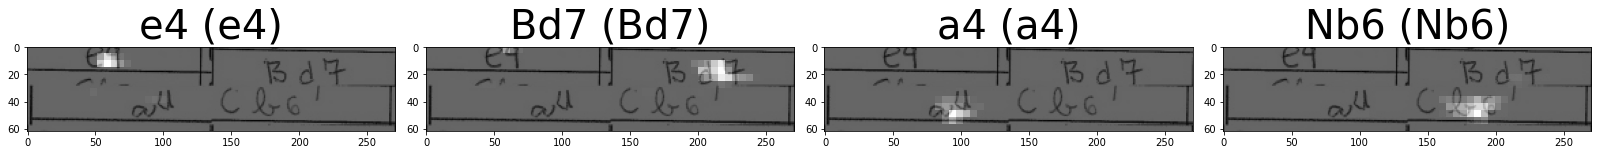

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'e6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


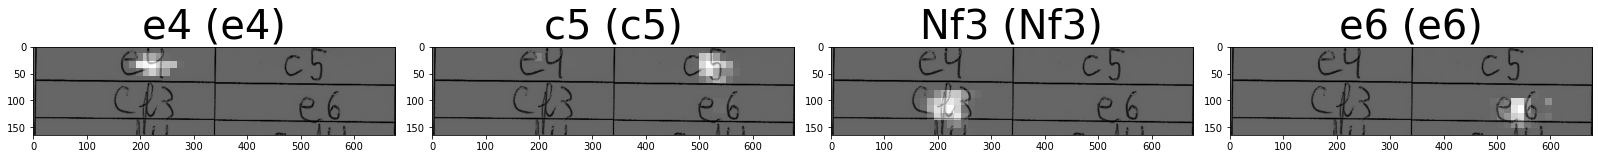

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


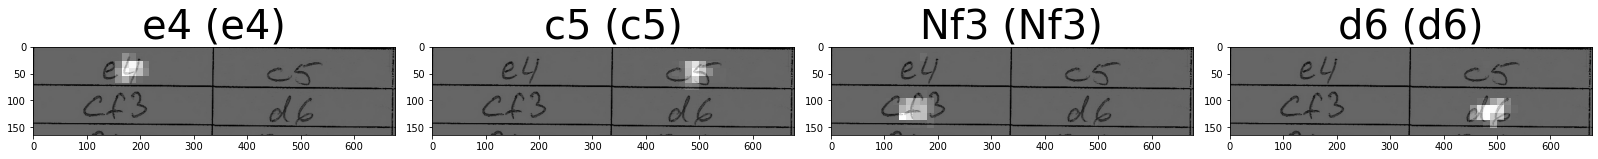

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


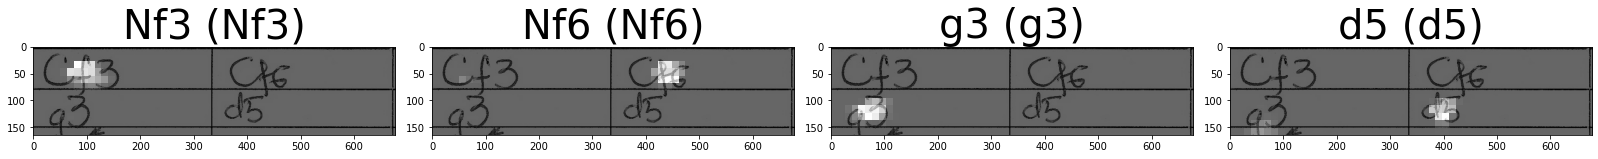

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3', 'e6']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


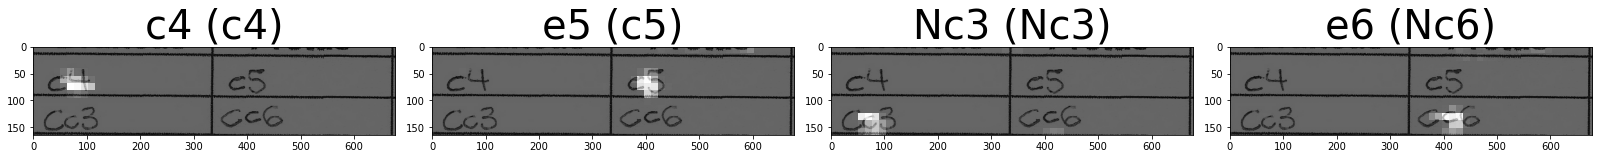

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'c4', 'a6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


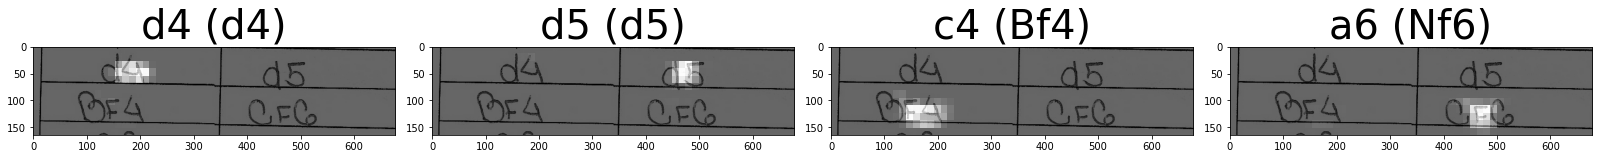

evaluating  100 ...
len 1 accuracy 0.8421052694320679 cir 0.07602339
len 2 accuracy 0.8157894611358643 cir 0.11695907
len 3 accuracy 0.8245614171028137 cir 0.109161794
len 4 accuracy 0.7960526347160339 cir 0.1260965


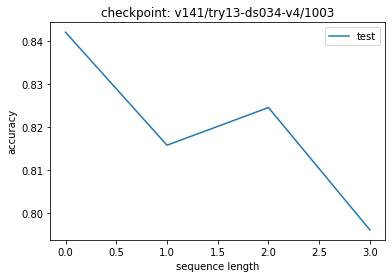

iniciando para lengh 4  target 0.1
len= 4  try_count= 0
-- loss_target=> 0.1  train_length= 4
Epoch 8 Batch 0 Loss 0.0181
Epoch 8 Batch 50 Loss 0.0116
Epoch 8 Batch 100 Loss 0.0127
Epoch 8 Batch 150 Loss 0.0415
Epoch 8 Batch 200 Loss 0.0212
Epoch 8 Batch 250 Loss 0.0472
Epoch 8 Batch 300 Loss 0.0375
Epoch 8 Batch 350 Loss 0.0313
Epoch 8 Batch 400 Loss 0.0241
Epoch 8 Batch 450 Loss 0.0100
Epoch 8 Batch 500 Loss 0.1313
Epoch 8 Batch 550 Loss 0.0239
Epoch 8 Loss 0.025801  acc: 0.9918 [ Validation Loss 0.168089 valid_acc: 0.9598 ]
Time taken for 1 epoch 987.3863589763641 sec

02:43:36.57
Target reached! stop!  len=  4
saved checkpoint! /content/drive/My Drive/mestrado/v141/try13-ds034-v4/1003/checkpoints/train/ckpt-32


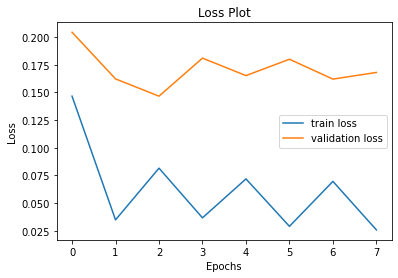

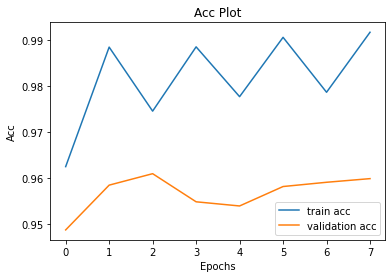

02:43:37.29
expected= ['Nc6', 'e6', 'Ne1', 'Nc6', '<end>']
predicted= ['Nc6', 'e6', 'Ne1', 'Nc6']
/content/dataset-v034--2lines-parts--40k-v4/train/images/shuffle-ec-only-35b4ffd4.jpg


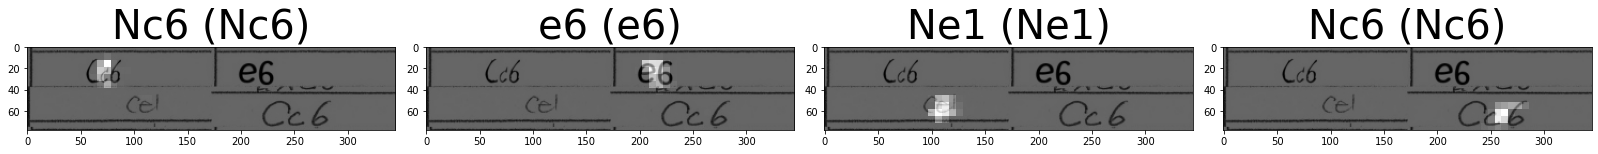

expected= ['e4', 'Bd7', 'a4', 'Nb6', '<end>']
predicted= ['e4', 'Bd7', 'a4', 'Nb6']
/content/dataset-v034--2lines-parts--40k-v4/valid/images/shuffled_02217.jpg


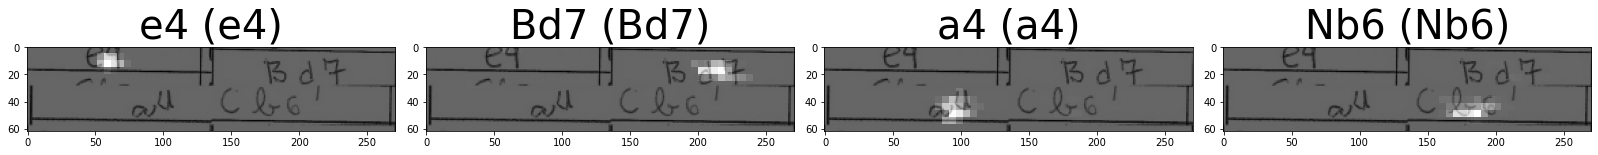

EVALUATING ALL DATA 114
evaluating  0 ...
------------------------ 0 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'e6']
expected ['e4', 'c5', 'Nf3', 'e6', 'd4', 'cxd4', 'Nxd4', 'a6', 'c4', 'Qc7', 'Nc3', 'Nf6', 'Be3', 'Bb4', 'Qd2', 'Nxe4']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0004_fullpage.jpg


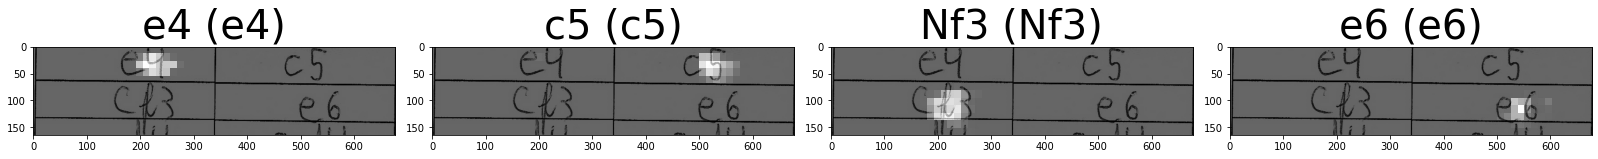

------------------------ 1 ------------------------------
predicted ['e4', 'c5', 'Nf3', 'd6']
expected ['e4', 'c5', 'Nf3', 'd6', 'Bb5+', 'Bd7', 'Bxd7+', 'Nxd7', 'O-O', 'Ngf6', 'Re1', 'e5', 'c3', 'Be7', 'd3', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0015_fullpage.jpg


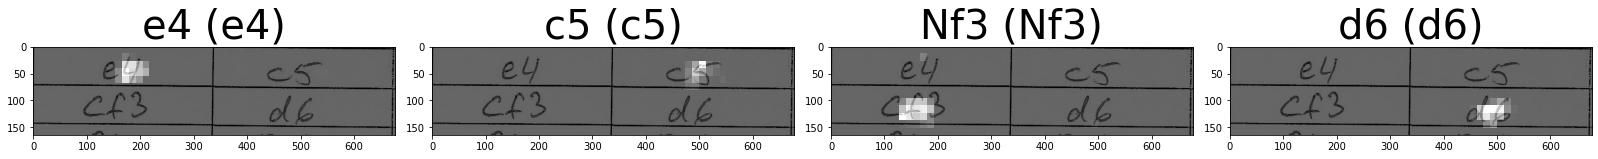

------------------------ 2 ------------------------------
predicted ['Nf3', 'Nf6', 'g3', 'd5']
expected ['Nf3', 'Nf6', 'g3', 'd5', 'c4', 'e6', 'b3', 'Be7', 'Bb2', 'O-O', 'Bg2', 'Nbd7', 'O-O', 'c6', 'd3', 'Re8']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0023_fullpage.jpg


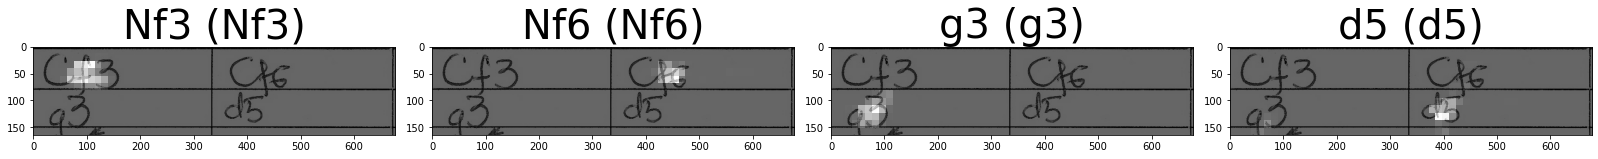

------------------------ 3 ------------------------------
predicted ['c4', 'e5', 'Nc3', 'e6']
expected ['c4', 'c5', 'Nc3', 'Nc6', 'g3', 'g6', 'Bg2', 'Bg7', 'Nf3', 'd6', 'O-O', 'e5', 'd3', 'Nge7', 'Rb1', 'O-O']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0029_fullpage.jpg


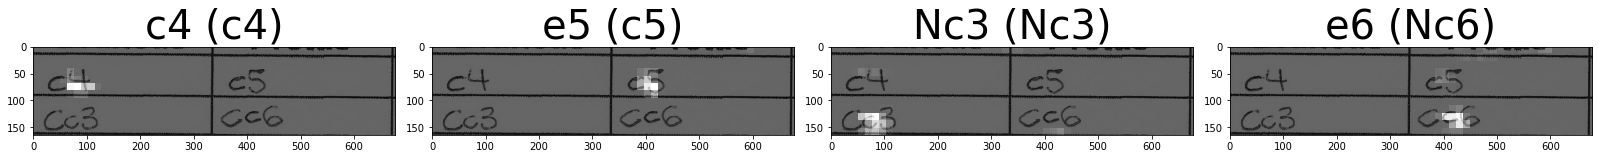

------------------------ 4 ------------------------------
predicted ['d4', 'd5', 'c4', 'g6']
expected ['d4', 'd5', 'Bf4', 'Nf6', 'e3', 'c5', 'c3', 'Qb6', 'Qb3', 'c4', 'Qc2', 'g6', 'Nd2', 'Nc6', 'e4', 'e6']
/content/new-random-8lines--v1--test-only-2lines/test/images/carnaval_0032_fullpage.jpg


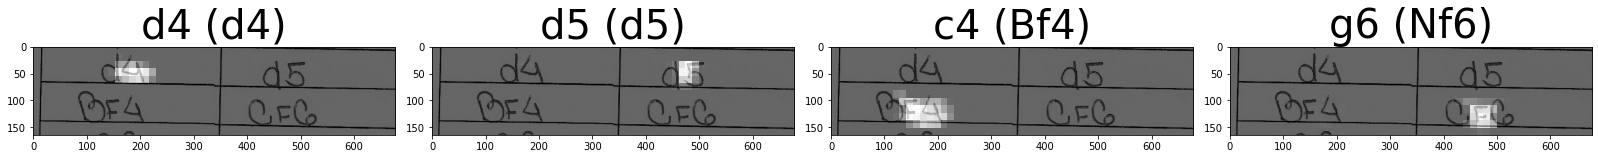

evaluating  100 ...
len 1 accuracy 0.8070175647735596 cir 0.09795322
len 2 accuracy 0.7982456088066101 cir 0.12280702
len 3 accuracy 0.8274853825569153 cir 0.10867447
len 4 accuracy 0.7938596606254578 cir 0.12865497


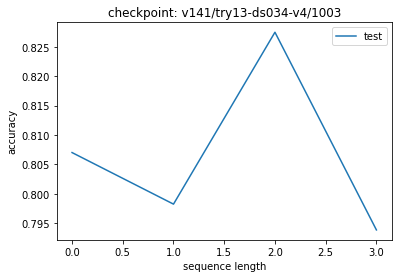

In [ ]:
for _len in [1,2,3,4]:
  for _target in [0.25,0.1]:
    print( 'iniciando para lengh', _len, ' target', _target)
    if not train_more_with_retry( _target, _len, 2000):
      print( 'numero de tentativas excedido sem sucesso. Abort')
      assert False

    print_time()    
    try:
      evaluate_train(1, _len)
      evaluate_valid(1, _len)
      make_evaluations_test_set(_len)
    except Exception as e:
      print( 'oops error..', e)